In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import save_model, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import floor

from keras import optimizers
from sklearn.metrics import mean_squared_error, mean_squared_log_error


# Keeping this as a reference for how we created the data
#train1 = pd.read_csv('train_1.csv', sep=',', header=0)
#train2 = pd.read_csv('train_2.csv', sep=',', header=0)
#train3 = pd.read_csv('train_3.csv', sep=',', header=0)
#train4 = pd.read_csv('train_4.csv', sep=',', header=0)
#train = pd.concat([train1, train2, train3, train4], ignore_index=True)
#test = pd.read_csv('test.csv', header=0)
#train = train[train['store_nbr'] == 1]
#train = train.drop(columns=["id", "store_nbr"], axis=1)
#train_data = train.pivot_table(index=['date'], columns="family", values='sales')
#train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)

11/11 [==============================] - 1s 5ms/step
Evaluation loss: 0.013577879406511784
Finished column 1
11/11 [==============================] - 1s 7ms/step
Evaluation loss: 0.0
Finished column 2
11/11 [==============================] - 1s 7ms/step
Evaluation loss: 0.013250497169792652
Finished column 3
11/11 [==============================] - 1s 7ms/step
Evaluation loss: 0.004227687604725361
Finished column 4
11/11 [==============================] - 1s 5ms/step
Evaluation loss: 0.0
Finished column 5
11/11 [==============================] - 1s 5ms/step
Evaluation loss: 0.007693619001656771
Finished column 6
11/11 [==============================] - 1s 7ms/step
Evaluation loss: 0.000450088526122272
Finished column 7
11/11 [==============================] - 1s 6ms/step
Evaluation loss: 0.00496320566162467
Finished column 8
11/11 [==============================] - 1s 5ms/step
Evaluation loss: 0.006678889039903879
Finished column 9
11/11 [==============================] - 1s 6ms/step
E

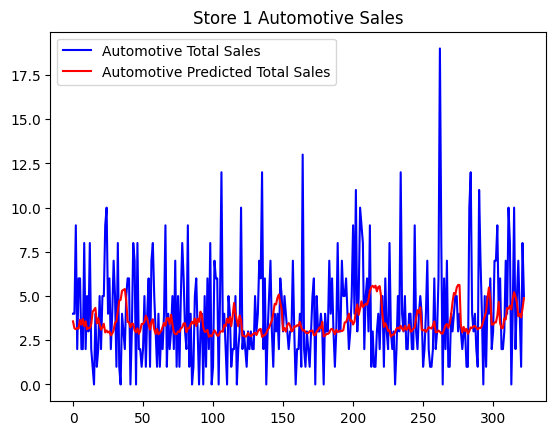

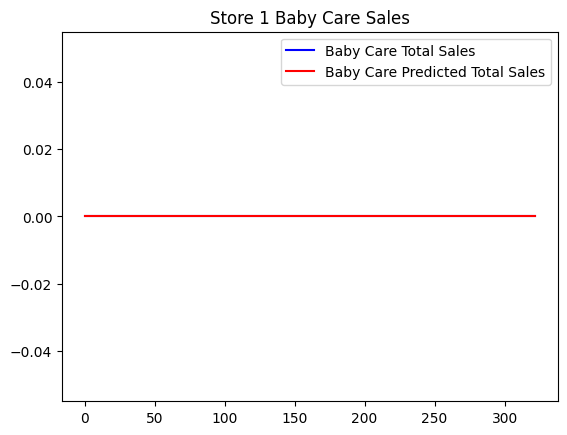

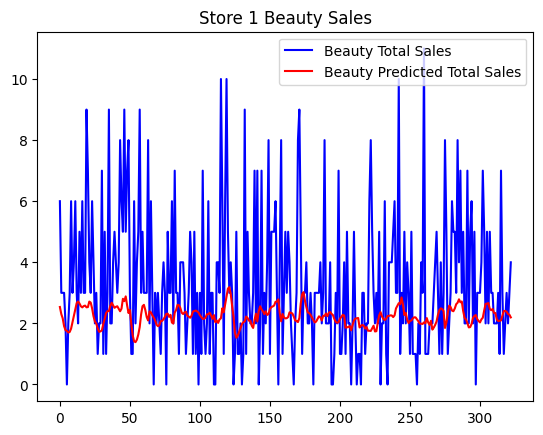

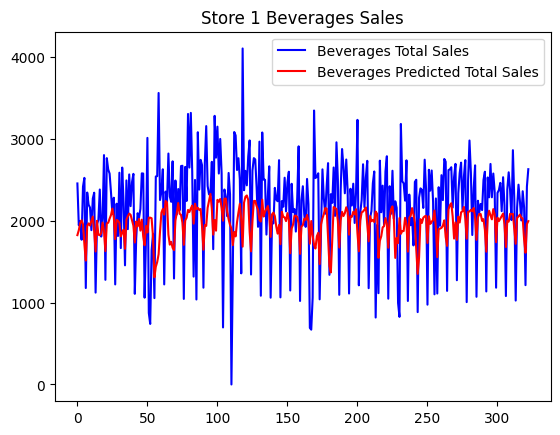

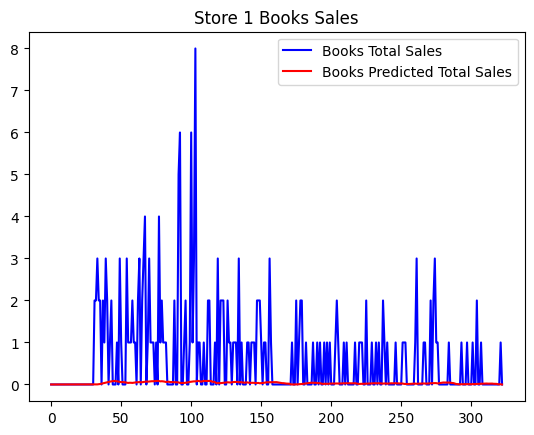

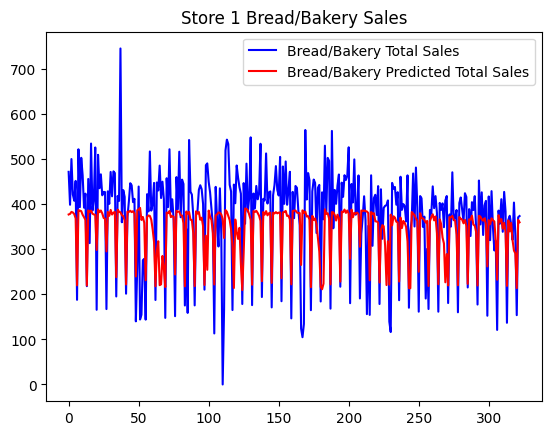

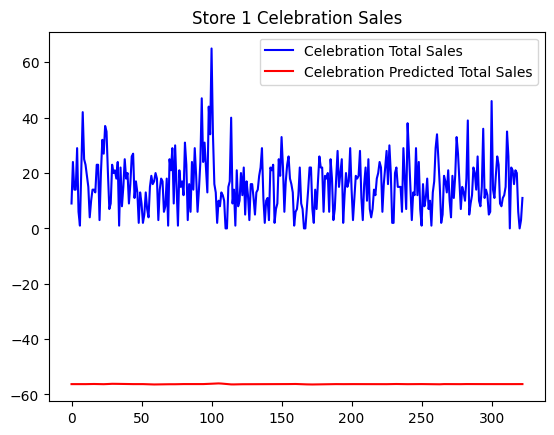

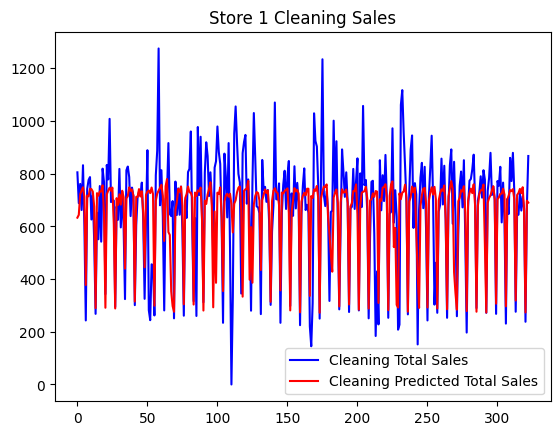

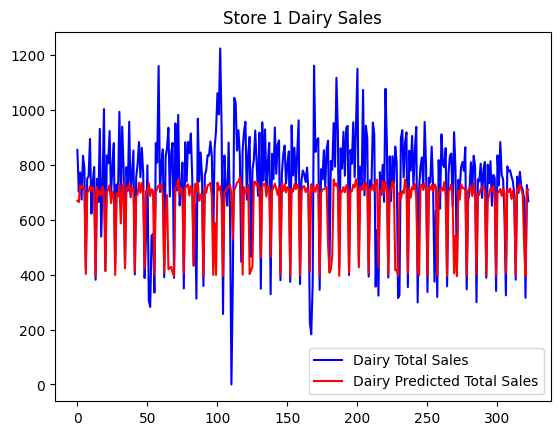

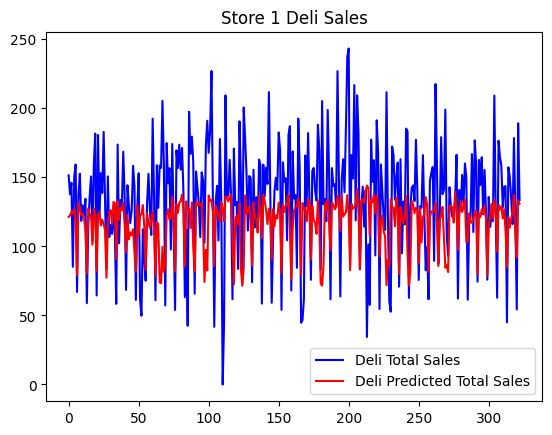

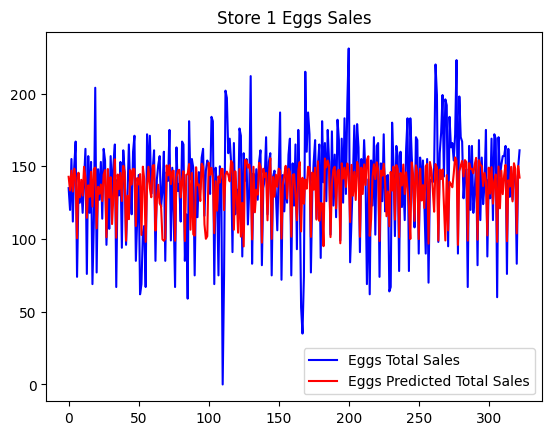

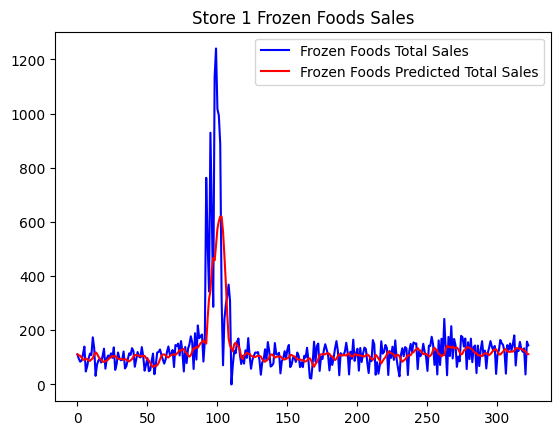

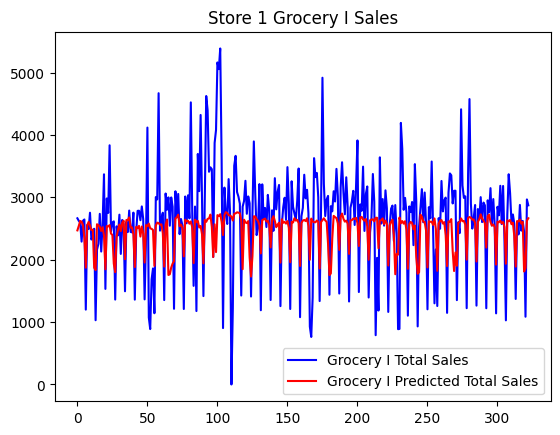

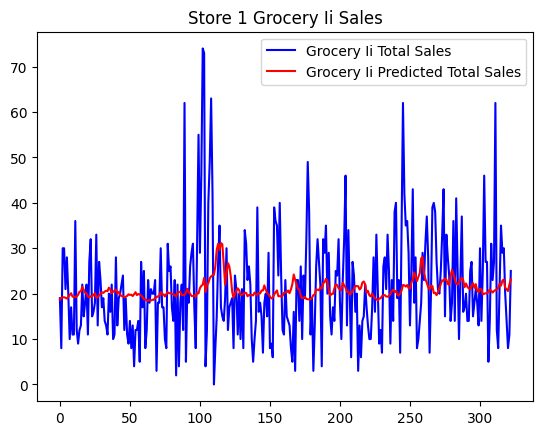

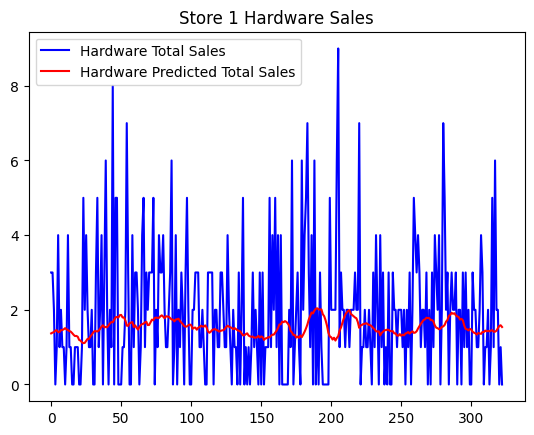

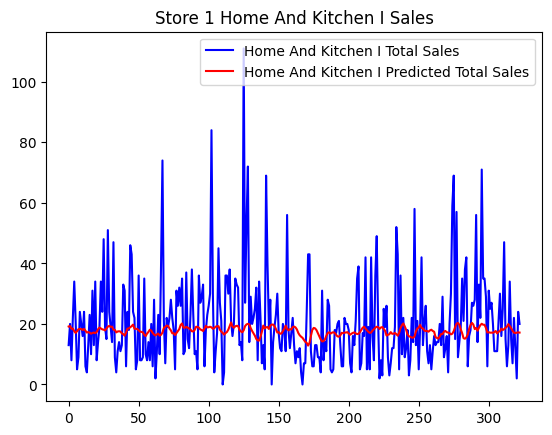

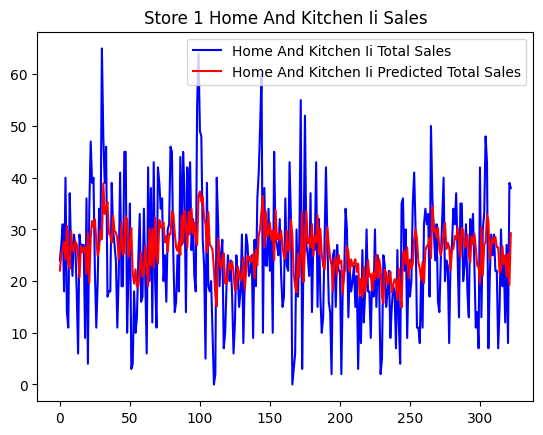

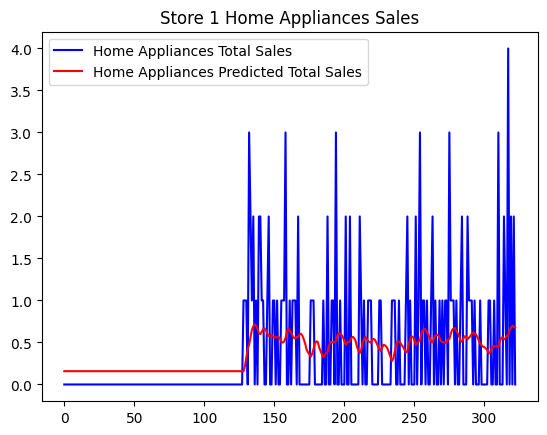

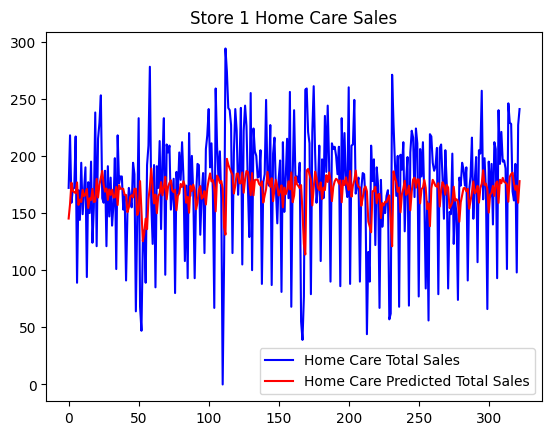

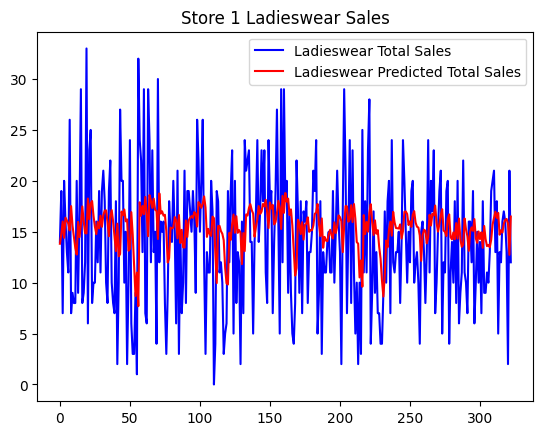

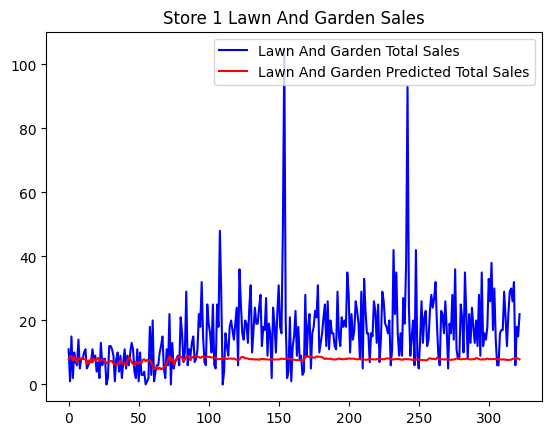

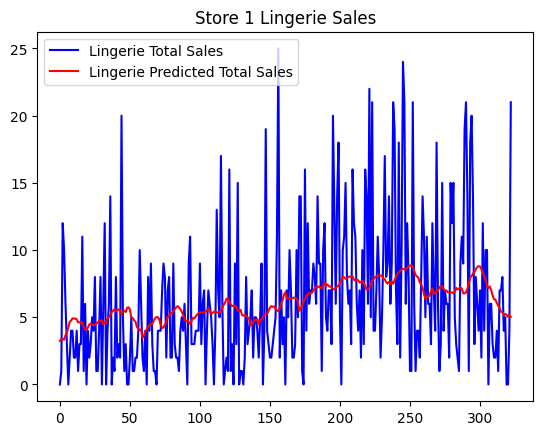

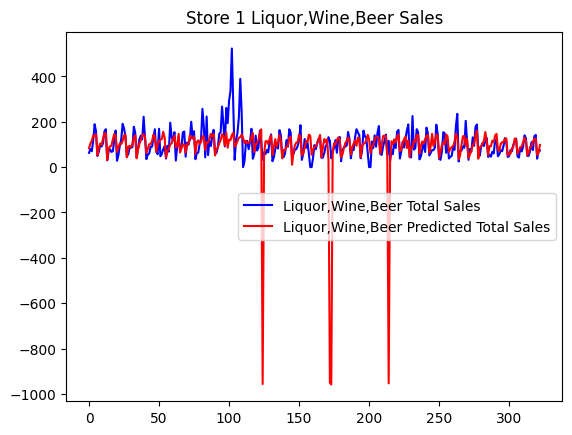

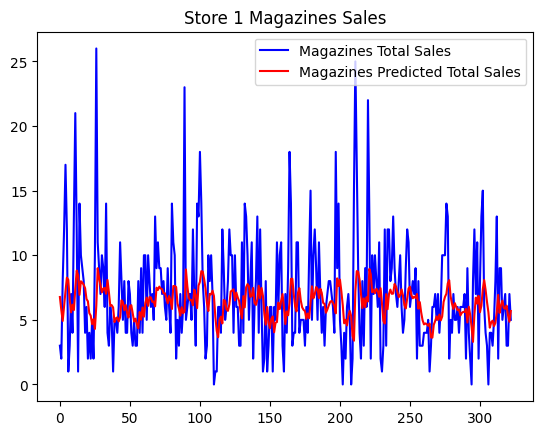

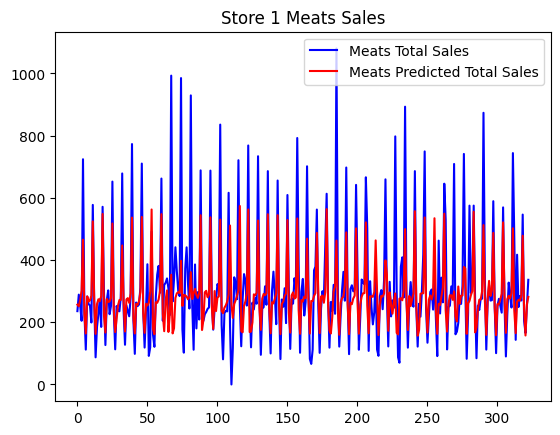

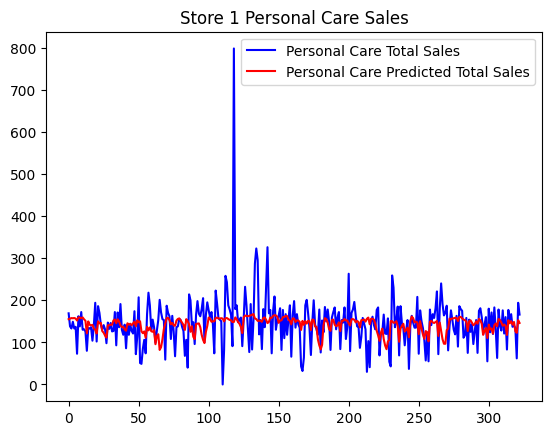

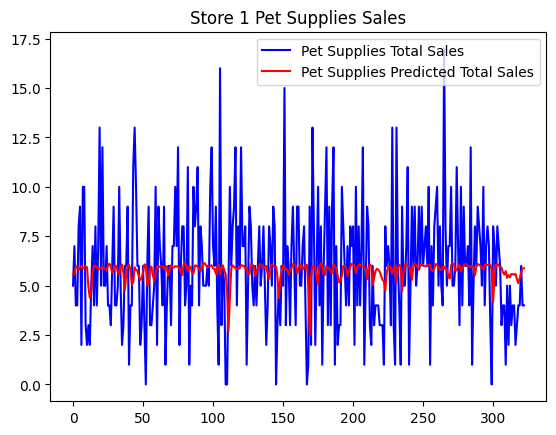

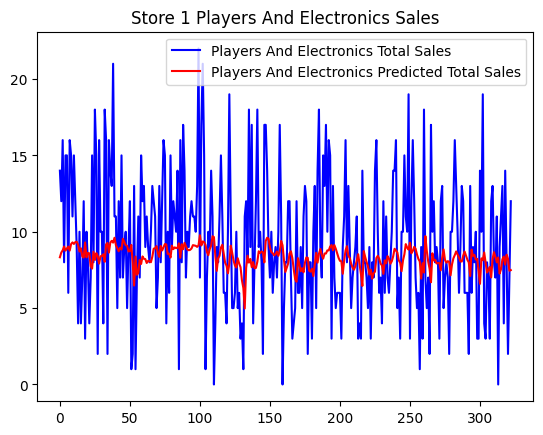

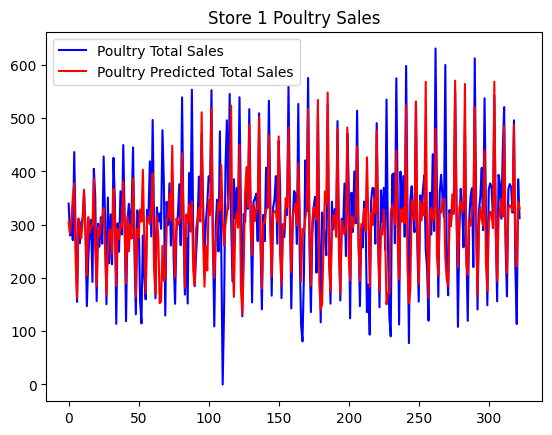

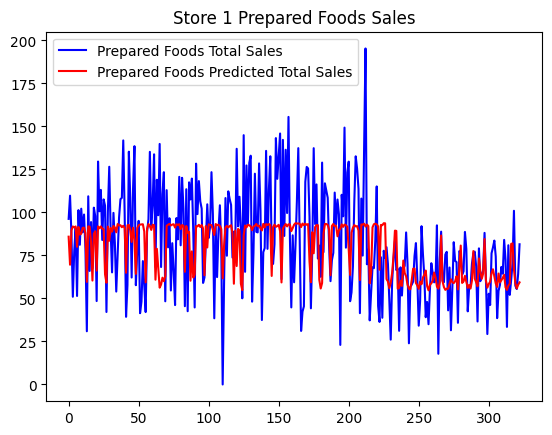

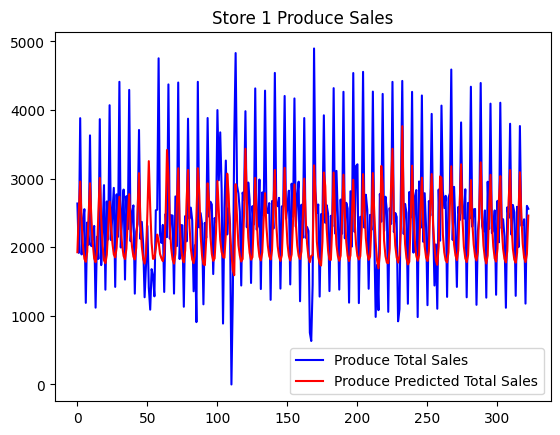

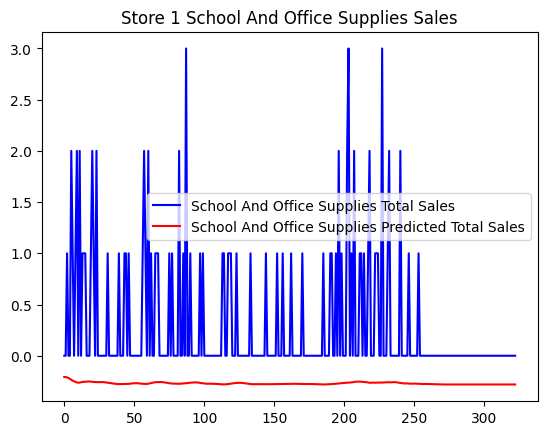

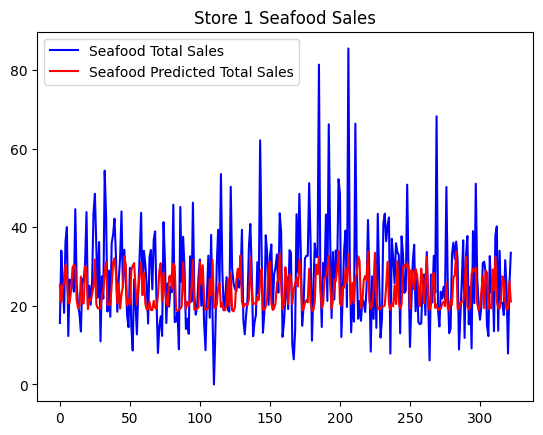

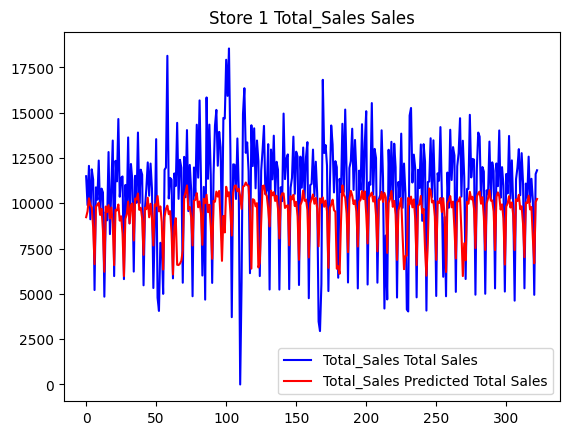

In [21]:
'''
LSTM
'''
def parse_data(column_index, scaler, steps):

    store_1_data = pd.read_csv("train_data_store_1.csv")
    if column_index == (len(store_1_data.columns)-1):
        total_sales = store_1_data.iloc[:,-1:].values
    else:
        total_sales = store_1_data.iloc[:, column_index: (column_index+1 if (column_index+1) <= (len(store_1_data.columns) - 1) else -1) ].values
 
    training_set = total_sales[:floor(len(total_sales)*.8)]
    testing_set = total_sales[floor(len(total_sales)*.8):]
    scaled_data = scaler.fit_transform(training_set)
    X_train = []
    y_train = []
    for i in range(steps, len(training_set)):
        X_train.append(scaled_data[i-steps:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train, total_sales, training_set, testing_set
def create_model(X_train):
    model = Sequential()
    model.add(LSTM(units=55, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=55, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=55, return_sequences=True))
    model.add(LSTM(units=55))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
    return model

def train_fit_predict(column_index, epochs, batch_size, steps):
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train, y_train, column_data, training_set, testing_set = parse_data(column_index, scaler, steps)
    model = create_model(X_train)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
    total_sales = column_data
    data = pd.DataFrame(total_sales[len(total_sales) - len(testing_set) - steps:]).values
    data = data.reshape(-1, 1)
    data = scaler.transform(data)
    X_test = []
    for i in range(steps, len(testing_set)):
        X_test.append(data[i-steps:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred = model.predict(X_test)
    pred = scaler.inverse_transform(pred)
    eval_res = model.evaluate(X_train, y_train, verbose=False)
    return pred, testing_set, eval_res

def predict_column(column_index_to_test, epochs, batch_size, steps):
    pred, testing_set, eval_res= train_fit_predict(column_index_to_test, epochs, batch_size, steps)
    print(f"Evaluation loss: {eval_res}")
    colNames = pd.read_csv("train_data_store_1.csv").columns
    return testing_set[:-steps], pred, colNames[column_index_to_test].title()

test_data, predictions, names = [], [], []
for i in range(1, 35):
    testing, prediction, name = predict_column(i, 40, 16, 14)
    test_data.append(testing)
    predictions.append(prediction)
    names.append(name)
    print(f"Finished column {i}")
for i, v in enumerate(test_data):
    plt.plot(test_data[i], color='blue', label=f"{names[i]} Total Sales")
    plt.plot(predictions[i], color='red', label=f"{names[i]} Predicted Total Sales")
    plt.title(f"Store 1 {names[i]} Sales")
    plt.legend()
    plt.show()

In [13]:
'''
MULTILAYER PERCEPTRON
'''
train1 = pd.read_csv('train_1.csv', sep=',', header=0)
train2 = pd.read_csv('train_2.csv', sep=',', header=0)
train3 = pd.read_csv('train_3.csv', sep=',', header=0)
train4 = pd.read_csv('train_4.csv', sep=',', header=0)
train = pd.concat([train1, train2, train3, train4], ignore_index=True)
test = pd.read_csv('test.csv', header=0)
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')
all_data = train.merge(transactions, on=['date', 'store_nbr'], how='left') # Left merge matches keys similar to SQL
all_data = all_data.merge(stores, on=['store_nbr'], how='left')
all_data['transactions'] = all_data['transactions'].fillna(0) # Fill empty with 0's
all_data = all_data.drop([ 'id', 'date' ], axis=1) # Drop non-features
working_data = all_data.copy()
working_data = pd.get_dummies(working_data) # One hot encode data
X = working_data.drop('sales', axis=1)
y = working_data['sales']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
batch_size = 2000
learn_rate = 0.0001
epochs = 40
multilayer_model = Sequential()
multilayer_model.add(Dense(80, activation='relu', input_dim=X_train.shape[1]))
multilayer_model.add(Dense(1))
multilayer_model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizers.Adam(learn_rate))
multilayer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dense_3 (Dense)             (None, 1)                 81        
                                                                 
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_history = multilayer_model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)

Epoch 1/40
961/961 [==============================] - 3s 2ms/step - loss: 8.3474 - val_loss: 8.3443
Epoch 2/40
961/961 [==============================] - 2s 2ms/step - loss: 5.5847 - val_loss: 6.2106
Epoch 3/40
961/961 [==============================] - 2s 2ms/step - loss: 4.3549 - val_loss: 5.0273
Epoch 4/40
961/961 [==============================] - 2s 2ms/step - loss: 3.6408 - val_loss: 4.2520
Epoch 5/40
961/961 [==============================] - 2s 2ms/step - loss: 3.1815 - val_loss: 3.7216
Epoch 6/40
961/961 [==============================] - 2s 2ms/step - loss: 2.8599 - val_loss: 3.3527
Epoch 7/40
961/961 [==============================] - 2s 2ms/step - loss: 2.6225 - val_loss: 3.0753
Epoch 8/40
961/961 [==============================] - 2s 2ms/step - loss: 2.4429 - val_loss: 2.8741
Epoch 9/40
961/961 [==============================] - 2s 2ms/step - loss: 2.3023 - val_loss: 2.7094
Epoch 10/40
961/961 [==============================] - 2s 2ms/step - loss: 2.1900 - val_loss: 2.5706

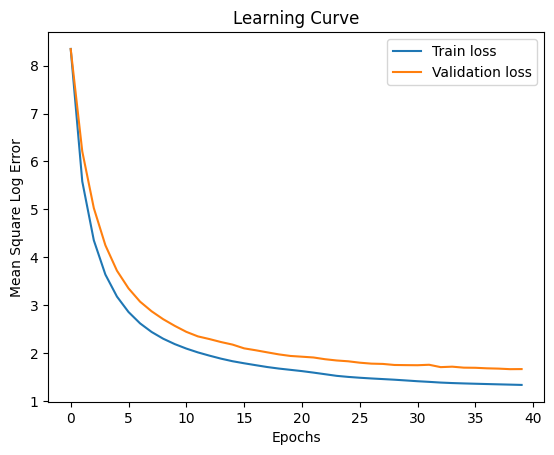

In [15]:
plt.plot(model_history.history['loss'], label='Train loss')
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Log Error")
plt.title('Learning Curve')
plt.legend()
plt.show()

In [16]:
prediction = multilayer_model.predict(X_test)
prediction = np.where(prediction<0, 0, prediction) # MSLE can't evaluate negative values
print(mean_squared_log_error(y_pred=prediction, y_true=y_test))

18756/18756 [==============================] - 12s 664us/step
1.3340735789879508


In [17]:
y_test_df = pd.DataFrame(y_test)
y_test_df = y_test_df.reset_index().drop('index', axis=1)
prediction_df = pd.DataFrame(prediction)

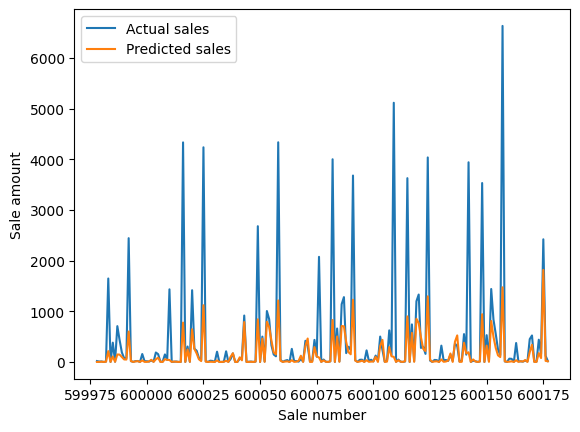

In [18]:
plt.plot(y_test_df[-200:], label='Actual sales')
plt.plot(prediction_df[-200:], label='Predicted sales')
plt.xlabel('Sale number')
plt.ylabel('Sale amount')
plt.legend()
plt.show()

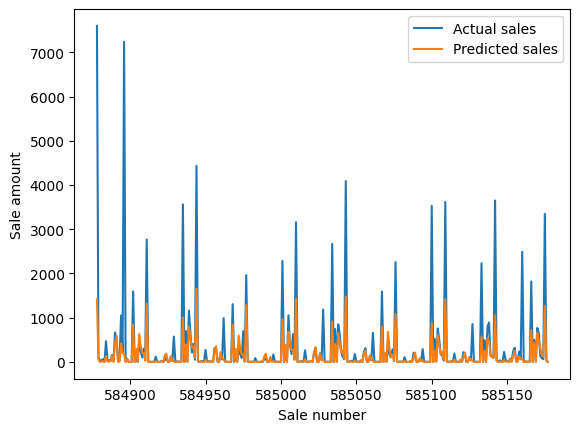

In [19]:
plt.plot(y_test_df[-15300:-15000], label='Actual sales')
plt.plot(prediction_df[-15300:-15000], label='Predicted sales')
plt.xlabel('Sale number')
plt.ylabel('Sale amount')
plt.legend()
plt.show()

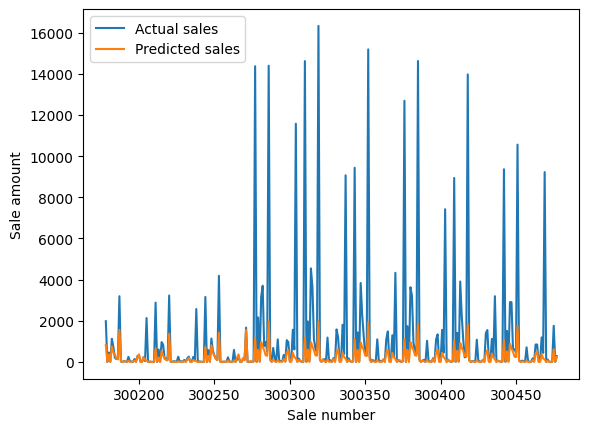

In [20]:
plt.plot(y_test_df[-300000:-299700], label='Actual sales')
plt.plot(prediction_df[-300000:-299700], label='Predicted sales')
plt.xlabel('Sale number')
plt.ylabel('Sale amount')
plt.legend()
plt.show()